In [23]:
import matplotlib.pyplot as plt
import sacc
import numpy as np
import os

In [24]:
def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [25]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [75]:
c = ['teal', 'powderblue', 'orange',  'cornflowerblue', 'tomato']
z = [0.25588604, 0.55455363, 0.91863365, 1.38232001, 2.]
nsbins = len(z)-1
def convert_to_z_labels(z):
    return ['$%0.2f < z < %0.2f$'%(z[i], z[i+1]) for i in range(len(z)-1)]
z_labels = convert_to_z_labels(z)
print(z_labels)

['$0.26 < z < 0.55$', '$0.55 < z < 0.92$', '$0.92 < z < 1.38$', '$1.38 < z < 2.00$']


In [140]:
def plot_xip(s, theory=None, datatype=None):
    plt.clf()
    fig, ax = plt.subplots(2, 2, figsize=(6., 6.), sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    for dt in s.get_data_types():
        #print(dt)
        if dt == datatype:
            for i in range(nsbins):

                theta, xi, cov = s.get_theta_xi(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)
                if i<2: j = 0 
                else: j = 1
                    
                if theory is not None:
                    theta_th, xi_th, cov_th = theory.get_theta_xi(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)

                    ax[j][i%2].plot(theta, xi_th, ls = '-', lw = '1.5', color = c[i], label = 'Theory')

                ax[j][i%2].errorbar(theta, xi, np.sqrt(np.diag(cov_th)), fmt = '.', capsize=1.5, elinewidth=0.8, color = c[i], label = 'Measurements')
                ax[j][i%2].text(0.5, 0.88, z_labels[i], horizontalalignment='center',
                              verticalalignment='center', transform=ax[j][i%2].transAxes)#, fontsize=12)
                ax[j][i%2].set_xscale('log')
                ax[j][i%2].set_yscale('log')
                if datatype=='galaxy_shear_xi_plus':
                    ax[j][i%2].set_ylim(4*10**(-7), 1.5*10**(-4))
                if datatype=='galaxy_shear_xi_minus':
                    ax[j][i%2].set_ylim(2*10**(-7), 7*10**(-5))
                
                if i>1: 
                    ax[j][i%2].set_xlabel(r'$\theta$ [arcmin]')
                if i%2<1:
                    if datatype=='galaxy_shear_xi_plus':
                        ax[j][i%2].set_ylabel(r'$\xi_+$')
                    if datatype=='galaxy_shear_xi_minus':
                        ax[j][i%2].set_ylabel(r'$\xi_-$')


    ax[1][0].legend(frameon = False, loc = 'lower left')

    return fig


In [128]:
def plot_xip_ratios(s, theory, datatype = None):
    plt.clf()
    fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    for dt in s.get_data_types():
        if dt == datatype:
            for i in range(nsbins):

                theta, xi, cov = s.get_theta_xi(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)
                theta_th, xi_th, cov_th = theory.get_theta_xi(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)

                if i<2: j = 0 
                else: j = 1              
                ax[j][i%2].errorbar(theta, xi/xi_th, np.sqrt(np.diag(cov_th))/xi_th, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[i], label ='Data/Theory')
                ax[j][i%2].text(0.5, 0.88, z_labels[i], horizontalalignment='center',
                              verticalalignment='center', transform=ax[j][i%2].transAxes, fontsize=12)
                ax[j][i%2].set_xscale('log')
                #ax[j][i%2].set_xlim(xmax = 100.)
                ax[j][i%2].set_ylim(0.5,1.5)
                ax[j][i%2].axhline(y=1., color = 'k', ls = ':')
                #ax[j][i%2].legend(frameon = False)
                if i>1: 
                    ax[j][i%2].set_xlabel(r'$\theta$ [arcmin]')
                if i%2<1:
                    if datatype=='galaxy_shear_xi_plus':
                        ax[j][i%2].set_ylabel(r'$\xi_+$ ratios')
                    if datatype=='galaxy_shear_xi_minus':
                        ax[j][i%2].set_ylabel(r'$\xi_-$ ratios')
                        
    ax[1][0].legend(frameon = False, loc = 'lower left')
    
    return fig


def plot_xip_errors_ratio(s, theory, datatype = None):
    plt.clf()
    fig, ax = plt.subplots(2, 2, figsize=(6., 6.), sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    for dt in s.get_data_types():
        if dt == datatype:
            for i in range(nsbins):

                theta, xi, cov = s.get_theta_xi(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)
                if i<2: j = 0 
                else: j = 1
                    
                theta_th, xi_th, cov_th = theory.get_theta_xi(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)

                ax[j][i%2].plot(theta, np.sqrt(np.diag(cov))/np.sqrt(np.diag(cov_th)), ls = '-', lw = '1.5', color = c[i], label = 'JK/Gaussian')

                ax[j][i%2].text(0.5, 0.88, z_labels[i], horizontalalignment='center',
                              verticalalignment='center', transform=ax[j][i%2].transAxes)#, fontsize=12)
                ax[j][i%2].set_xscale('log')
                ax[j][i%2].axhline(y=1., color = 'k', ls = ':')
                
                if i>1: 
                    ax[j][i%2].set_xlabel(r'$\theta$ [arcmin]')
                if i%2<1:
                    if datatype=='galaxy_shear_xi_plus':
                        ax[j][i%2].set_ylabel(r'$\sigma(\xi_+)$ ratios')
                    if datatype=='galaxy_shear_xi_minus':
                        ax[j][i%2].set_ylabel(r'$\sigma(\xi_-)$ ratios')
                    

    ax[1][0].legend(frameon = False, loc = 'lower left')

    return fig

In [102]:
def get_mean(s, dt):
    dps = s.get_data_points(dt)
    mean = []
    for dp in dps:
        mean.append(dp.value)
    mean = np.array(mean)
    return mean

def get_cov(s, dt):
    ind = s.indices(dt)
    cov = s.covariance.get_block(ind)
    return cov
    
def compute_chi2_gauss(data, theory, dt):
    data_mean = get_mean(data, dt)
    theory_mean = get_mean(theory, dt)
    
    cov = get_cov(theory, dt)
    invcov = np.linalg.inv(cov)
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov

def compute_chi2_jk(data, theory, dt):
    data_mean = get_mean(data, dt)
    theory_mean = get_mean(theory, dt)
    
    cov = get_cov(data, dt)
    invcov = np.linalg.inv(cov)
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov


def compute_chi2_bin(data, theory, dt):
    deltachi2_jk = []
    deltachi2_gauss = []
    
    for i in range(nsbins):
        theta_data, xi_data, cov_data = data.get_theta_xi(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)
        theta_th, xi_th, cov_th = theory.get_theta_xi(dt,'source_%s'%i , 'source_%s'%i, return_cov = True)

        assert(np.isclose(theta_data,theta_th).all())

        invcov_jk = np.linalg.inv(cov_data) 
        invcov_gauss = np.linalg.inv(cov_th)
        #if i == 0:
        #    print(cov_th[0])
        #    print(invcov_gauss[0])
            
        deltachi2_jk.append(np.dot(np.dot(xi_data-xi_th, invcov_jk), xi_data-xi_th))
        deltachi2_gauss.append(np.dot(np.dot(xi_data-xi_th, invcov_gauss), xi_data-xi_th))

    ndf = len(theta_data)
    
    return deltachi2_gauss, deltachi2_jk, ndf

def corrmatrix(cov):
    cov = np.mat(cov)
    D = np.diag(np.sqrt(np.diag(cov)))
    d = np.linalg.inv(D)
    corr = d*cov*d
    return corr

def plot_cov(cov, size):
    
    ncov1 = len(cov)
    ncov2 = len(cov[0])
    
    corr = corrmatrix(cov)
    cov_vmin = np.min(corr)
    
    figsize1 = 1.22222222227*ncov1/size
    figsize2 = ncov2/size
    fig, ax = plt.subplots(1, 1, figsize=(figsize1, figsize2))
    im = ax.imshow(corr, interpolation='nearest',
                           aspect='auto', origin='lower', vmin=-0.5, vmax=1.)
    cbar = fig.colorbar(im)
    return fig

## With shape noise run

In [48]:
dir = '../data_vectors/max_100arcmin/4sbins/'
file = 'twopoint_data_real.sacc' 
d = sacc.Sacc.load_fits(dir+file)
file = 'twopoint_theory_real.sacc'
t = sacc.Sacc.load_fits(dir+file)
make_directory(dir + 'plots/')
for dt in d.get_data_types():
        print(dt)
print ('----')
for dt in t.get_data_types():
        print(dt)
print ('----') 

galaxy_density_xi
galaxy_shearDensity_xi_t
galaxy_shear_xi_minus
galaxy_shear_xi_plus
----
galaxy_density_xi
galaxy_shearDensity_xi_t
galaxy_shear_xi_minus
galaxy_shear_xi_plus
----


delta chi2 xip (Gaussian cov) = 136.7
ndf = 150
delta chi2 xim (Gaussian cov) = 121.3
ndf = 150
delta chi2 xip (JK cov) =-33576473188379704.0
ndf = 150
delta chi2 xim (JK cov) =67071260897608848.0
ndf = 150


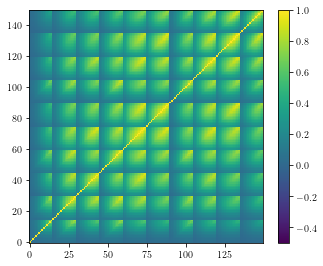

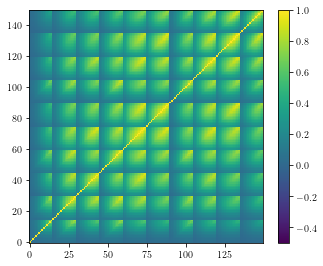

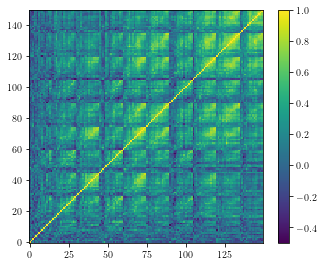

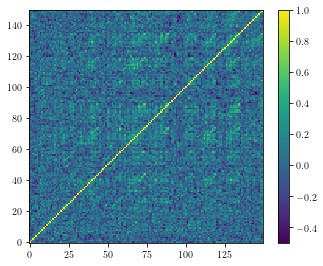

In [114]:
# get chi2s & plot covs
deltachi2, ndf, cov = compute_chi2_gauss(d, t, 'galaxy_shear_xi_plus')
print('delta chi2 xip (Gaussian cov) = %0.1f'%deltachi2)
print('ndf =', ndf)
fig = plot_cov(cov, size = 35.)
plt.savefig(dir + 'plots/cov_xip_gauss.png', dpi = 300)
deltachi2, ndf, cov = compute_chi2_gauss(d, t, 'galaxy_shear_xi_minus')
print('delta chi2 xim (Gaussian cov) = %0.1f'%deltachi2)
print('ndf =', ndf)
fig = plot_cov(cov, size = 35.)
plt.savefig(dir + 'plots/cov_xim_gauss.png', dpi = 300)

# same with JK cov
deltachi2, ndf, cov = compute_chi2_jk(d, t, 'galaxy_shear_xi_plus')
print('delta chi2 xip (JK cov) =%0.1f'%deltachi2)
print('ndf =', ndf)
fig = plot_cov(cov, size = 35.)
plt.savefig(dir + 'plots/cov_xip_jk.png', dpi = 300)
deltachi2, ndf, cov = compute_chi2_jk(d, t, 'galaxy_shear_xi_minus')
print('delta chi2 xim (JK cov) =%0.1f'%deltachi2)
print('ndf =', ndf)
fig = plot_cov(cov, size = 35.)
plt.savefig(dir + 'plots/cov_xim_jk.png', dpi = 300)

In [106]:
dchi2_gauss, dchi2_jk, ndf = compute_chi2_bin(d, t, 'galaxy_shear_xi_plus')
print ('Delta chi2 per bin xip (Gaussian cov):', (str(['%0.1f' % i for i in dchi2_gauss]).replace("'", "")))
print ('Delta chi2 per bin xip (JK cov):', (str(['%0.1f' % i for i in dchi2_jk]).replace("'", "")))
print ('ndf:', ndf)

dchi2_gauss, dchi2_jk, ndf = compute_chi2_bin(d, t, 'galaxy_shear_xi_minus')
print ('Delta chi2 per bin xim (Gaussian cov):', (str(['%0.1f' % i for i in dchi2_gauss]).replace("'", "")))
print ('Delta chi2 per bin xim (JK cov):', (str(['%0.1f' % i for i in dchi2_jk]).replace("'", "")))
print ('ndf:', ndf)

Delta chi2 per bin xip (Gaussian cov): [11.9, 20.1, 8.9, 13.0]
Delta chi2 per bin xip (JK cov): [39.3, 31.6, 13.6, 21.8]
ndf: 15
Delta chi2 per bin xim (Gaussian cov): [11.2, 6.5, 16.6, 15.0]
Delta chi2 per bin xim (JK cov): [20.4, 30.7, 31.6, 16.0]
ndf: 15


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

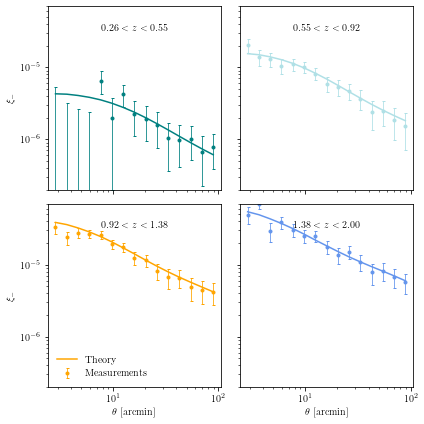

In [142]:
fig = plot_xip(d, theory = t, datatype = 'galaxy_shear_xi_plus')
plt.tight_layout()
plt.savefig(dir + 'plots/xip.png', dpi = 300)

fig = plot_xip(d, theory = t, datatype = 'galaxy_shear_xi_minus')
plt.tight_layout()
plt.savefig(dir + 'plots/xim.png', dpi = 300)

/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

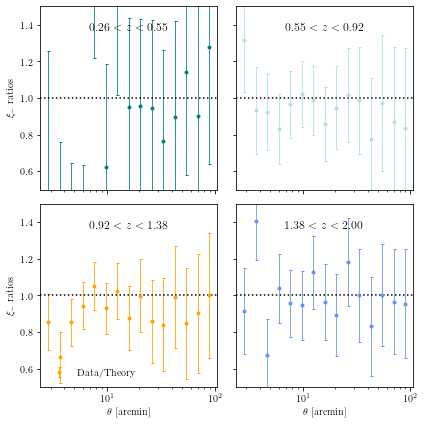

In [126]:
fig = plot_xip_ratios(d, t, datatype = 'galaxy_shear_xi_plus')
plt.tight_layout()
plt.savefig(dir + 'plots/xip_ratios.png', dpi = 300)

fig = plot_xip_ratios(d, t, datatype = 'galaxy_shear_xi_minus')
plt.tight_layout()
plt.savefig(dir + 'plots/xim_ratios.png', dpi = 300)

/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

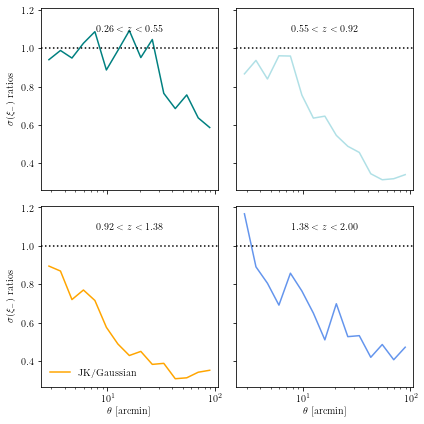

In [129]:
fig = plot_xip_errors_ratio(d, t, datatype = 'galaxy_shear_xi_plus')
plt.tight_layout()
plt.savefig(dir + 'plots/xip_errors_ratio.png', dpi = 300)

fig = plot_xip_errors_ratio(d, t, datatype = 'galaxy_shear_xi_minus')
plt.tight_layout()
plt.savefig(dir + 'plots/xim_errors_ratio.png', dpi = 300)

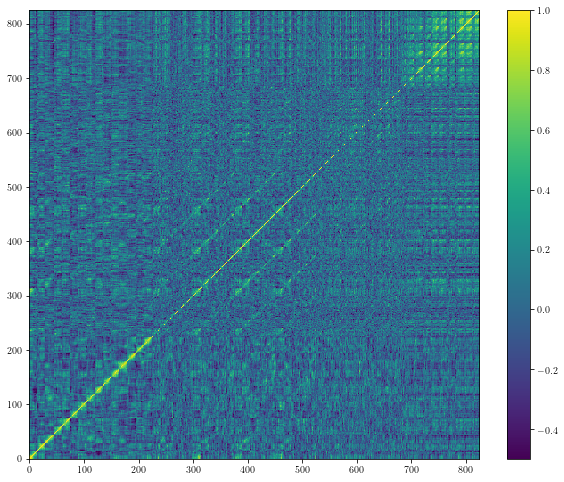

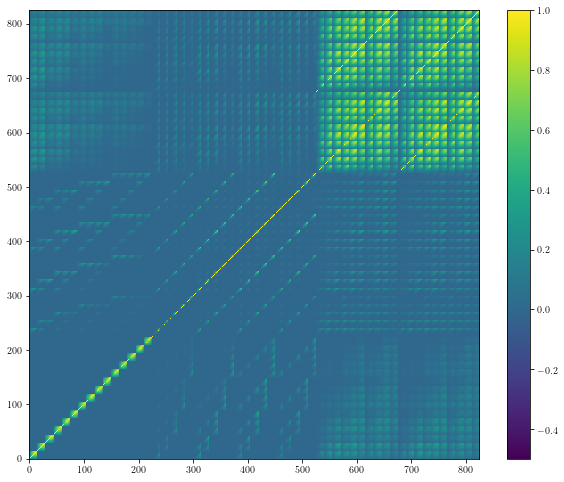

In [53]:
cov = d.covariance.covmat
fig = plot_cov(cov, size = 100.)
plt.savefig(dir + 'plots/cov_real_full_jk.png', dpi = 300)

cov = t.covariance.covmat
fig = plot_cov(cov, size = 100.)
plt.savefig(dir + 'plots/cov_real_full_gauss.png', dpi = 300)

## No Shape Noise

In [143]:
dir_no_sn = '../data_vectors/max_100arcmin/no_shape_noise_4sbins/'
file = 'twopoint_data_real.sacc' 
d_no_sn = sacc.Sacc.load_fits(dir_no_sn + file)
file = 'twopoint_theory_real.sacc'
t_no_sn = sacc.Sacc.load_fits(dir_no_sn + file)

make_directory(dir_no_sn + 'plots/')

delta chi2 xip (Gaussian cov) = 36486.2
ndf = 150
delta chi2 xim (Gaussian cov)= 39087.5
ndf = 150
delta chi2 xip (JK cov) = 9915639829473992.0
ndf = 150
delta chi2 xim (JK cov) = -8259117331138688.0
ndf = 150


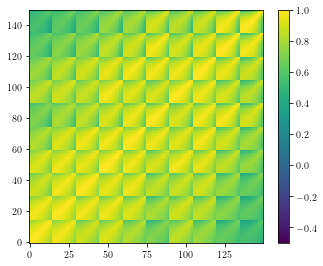

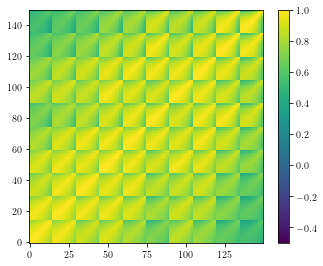

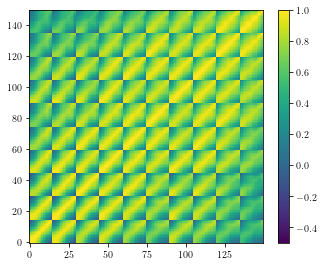

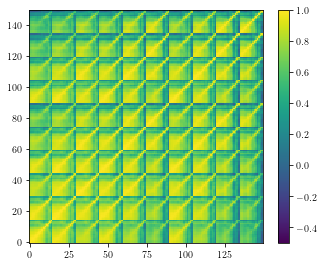

In [144]:
# get chi2s & plot covs Gaussian
deltachi2, ndf, cov = compute_chi2_gauss(d_no_sn, t_no_sn, 'galaxy_shear_xi_plus')
print('delta chi2 xip (Gaussian cov) = %0.1f'%deltachi2)
print('ndf =', ndf)
fig = plot_cov(cov, size = 35.)
plt.savefig(dir_no_sn + 'plots/cov_xip_gauss.png', dpi = 300)

deltachi2, ndf, cov = compute_chi2_gauss(d_no_sn, t_no_sn, 'galaxy_shear_xi_minus')
print('delta chi2 xim (Gaussian cov)= %0.1f'%deltachi2)
print('ndf =', ndf)
fig = plot_cov(cov, size = 35.)
plt.savefig(dir_no_sn + 'plots/cov_xim_gauss.png', dpi = 300)


# get chi2s & plot covs JK
deltachi2, ndf, cov = compute_chi2_jk(d_no_sn, t_no_sn, 'galaxy_shear_xi_plus')
print('delta chi2 xip (JK cov) = %0.1f'%deltachi2)
print('ndf =', ndf)
fig = plot_cov(cov, size = 35.)
plt.savefig(dir_no_sn + 'plots/cov_xip_jk.png', dpi = 300)

deltachi2, ndf, cov = compute_chi2_jk(d_no_sn, t_no_sn, 'galaxy_shear_xi_minus')
print('delta chi2 xim (JK cov) = %0.1f'%deltachi2)
print('ndf =', ndf)
fig = plot_cov(cov, size = 35.)
plt.savefig(dir_no_sn + 'plots/cov_xim_jk.png', dpi = 300)

In [145]:
dchi2_gauss, dchi2_jk, ndf = compute_chi2_bin(d_no_sn, t_no_sn, 'galaxy_shear_xi_plus')
print ('Delta chi2 per bin xip (Gaussian cov):', (str(['%0.1f' % i for i in dchi2_gauss]).replace("'", "")))
print ('Delta chi2 per bin xip (JK cov):', (str(['%0.1f' % i for i in dchi2_jk]).replace("'", "")))
print ('ndf:', ndf)

dchi2_gauss, dchi2_jk, ndf = compute_chi2_bin(d_no_sn, t_no_sn, 'galaxy_shear_xi_minus')
print ('Delta chi2 per bin xim (Gaussian cov):', (str(['%0.1f' % i for i in dchi2_gauss]).replace("'", "")))
print ('Delta chi2 per bin xim (JK cov):', (str(['%0.1f' % i for i in dchi2_jk]).replace("'", "")))
print ('ndf:', ndf)

Delta chi2 per bin xip (Gaussian cov): [6124.7, 5701.7, 5408.5, 5463.6]
Delta chi2 per bin xip (JK cov): [3285.4, 5134.6, 8455.9, 6171.2]
ndf: 15
Delta chi2 per bin xim (Gaussian cov): [5820.7, 6096.4, 6776.9, 6991.5]
Delta chi2 per bin xim (JK cov): [9688.7, 44934.6, 26999.1, 12775.4]
ndf: 15


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

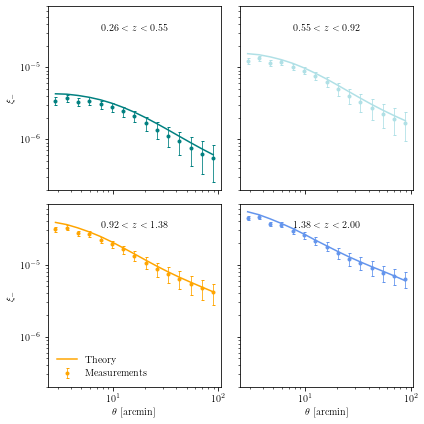

In [146]:
fig = plot_xip(d_no_sn, theory=t_no_sn, datatype = 'galaxy_shear_xi_plus')
plt.tight_layout()
plt.savefig(dir_no_sn + 'plots/xip.png', dpi = 300)

fig = plot_xip(d_no_sn, theory=t_no_sn, datatype = 'galaxy_shear_xi_minus')
plt.tight_layout()
plt.savefig(dir_no_sn + 'plots/xim.png', dpi = 300)

/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

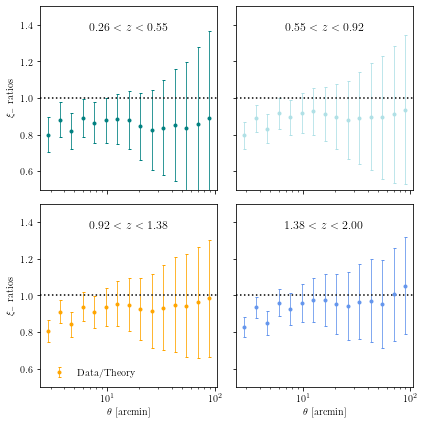

In [147]:
fig = plot_xip_ratios(d_no_sn, theory=t_no_sn, datatype = 'galaxy_shear_xi_plus')
plt.tight_layout()
plt.savefig(dir_no_sn + 'plots/xip_ratios.png', dpi = 300)

fig = plot_xip_ratios(d_no_sn, theory=t_no_sn, datatype = 'galaxy_shear_xi_minus')
plt.tight_layout()
plt.savefig(dir_no_sn + 'plots/xim_ratios.png', dpi = 300)

/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

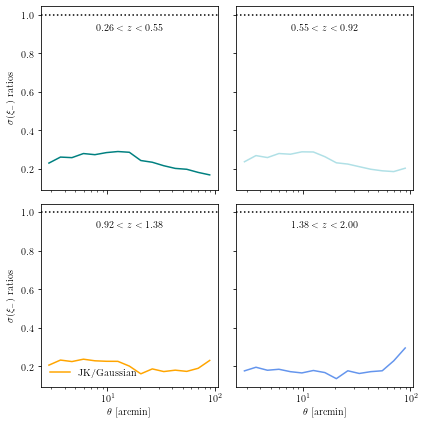

In [150]:
fig = plot_xip_errors_ratio(d_no_sn, t_no_sn, datatype = 'galaxy_shear_xi_plus')
plt.tight_layout()
plt.savefig(dir_no_sn + 'plots/xip_errors_ratio.png', dpi = 300)

fig = plot_xip_errors_ratio(d_no_sn, t_no_sn, datatype = 'galaxy_shear_xi_minus')
plt.tight_layout()
plt.savefig(dir_no_sn + 'plots/xim_errors_ratio.png', dpi = 300)

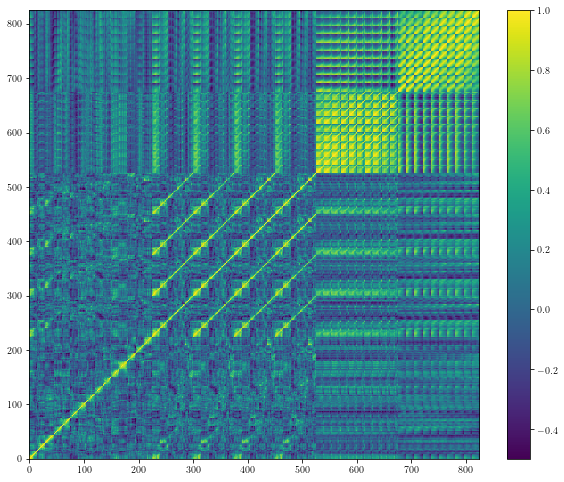

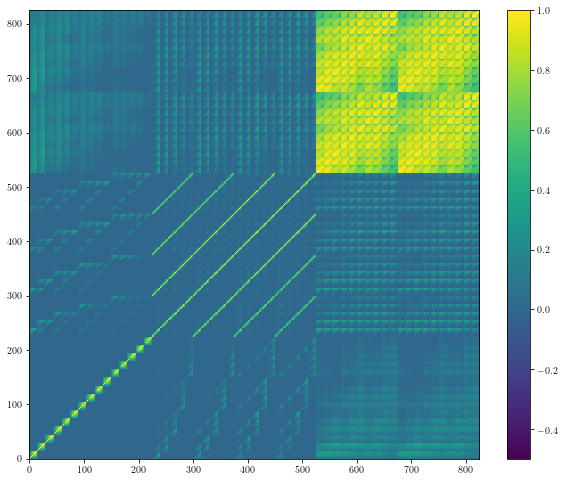

In [149]:
cov = d_no_sn.covariance.covmat
fig = plot_cov(cov, size = 100.)
plt.savefig(dir_no_sn + 'plots/cov_real_full_jk.png', dpi = 300)

cov = t_no_sn.covariance.covmat
fig = plot_cov(cov, size = 100.)
plt.savefig(dir_no_sn + 'plots/cov_real_full_gauss.png', dpi = 300)